In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score

from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_columns', None)

In [2]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [3]:
# Load (preprocessed) data
# 
# The raw data was downloaded from https://data.stanford.edu/hcmst and preprocessed.
# We combined data sets collected across several years, we transformed select variables 
# (e.g., partner_education to be at the same level of granularity as education),
# and added variables like the absolute age difference, education difference, etc.
# Finally, we determined whether couples were still together (i.e., our labels).
#
# We provide the preprocessed data as a csv file in the same repo as this notebook.

df = pd.read_csv('couples.csv')

# Order features (numeric first, categorical second) since it's convenient later
feature_order = ['age',
                 'partner_age',
                 'age_diff_abs',
                 'children',
                 'visits_relatives',
                 'education',
                 'marital_status',
                 'partner_education',
                 'gender',
                 'house',
                 'income',
                 'msa',
                 'rent',
                 'political',
                 'religion',
                 'work',
                 'gender_older',
                 'education_difference',
                 'success']

data = df[feature_order]
data = data[data.house != 'boat, rv, van, etc.'] # only one data point with this value, discard

labels = data.pop('success')

In [4]:
# Take a peak at the data
data.head()

,age,partner_age,age_diff_abs,children,visits_relatives,education,marital_status,partner_education,gender,house,income,msa,rent,political,religion,work,gender_older,education_difference
0,52,48,4,0.0,0,bachelor's degree or higher,living with partner,some college,female,a building with 2 or more apartments,"$20,000 to $24,999",metro,rented for cash,democrat,catholic,working - as a paid employee,1,1
1,28,30,2,0.0,0,bachelor's degree or higher,living with partner,bachelor's degree or higher,female,a building with 2 or more apartments,"$40,000 to $49,999",metro,rented for cash,democrat,jewish,working - as a paid employee,0,0
2,31,40,9,0.0,1,some college,never married,high school,male,a building with 2 or more apartments,"$40,000 to $49,999",metro,owned or being bought by you or someone in you...,democrat,"other non-christian, please specify:",working - as a paid employee,1,1
3,53,55,2,0.0,1,bachelor's degree or higher,living with partner,bachelor's degree or higher,male,a one-family house detached from any other house,"$125,000 to $149,999",metro,owned or being bought by you or someone in you...,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,1,0
4,58,51,7,0.0,0,bachelor's degree or higher,separated,bachelor's degree or higher,male,a building with 2 or more apartments,"$15,000 to $19,999",metro,rented for cash,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,0,0


In [5]:
# Define categorical names and indices
categorical_features = list(data.columns[5:])
categorical_idx = list(range(5, len(data.columns)))
continuous_features = list(data.columns[0:5])
continuous_idx = list(range(0,5))

X = data.values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)

# Train test split
train, test, labels_train, labels_test = train_test_split(
    X, labels, train_size=0.70, random_state=42
)

In [6]:
labels_train.unique(), labels_test.unique()

(array([ 1.,  0.]), array([ 1.,  0.]))

In [7]:
# Preprocessing pipeline
#      
# LIME needs a function that takes raw inputs and returns a prediction (see below).     
# We use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME (see below). 
# There are several ways to build this pipeline. For demo purposes, we here show the verbose option (and we
# avoid scaling one-hot encoded features).

continuous_pipeline = Pipeline([
    ('selector', DataSelector(continuous_idx)),
    ('scaler', StandardScaler()),
    ])

categorical_pipeline = Pipeline([
    ('selector', DataSelector(categorical_idx)),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("continuous_pipeline", continuous_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ])

# There are less verbose alternatives, especially if we scale one-hot encoded features,
# an accepted practice in the machine learning community:
#
#     preprocessing_pipeline = Pipeline([
#        ('onehotencoder', OneHotEncoder(categorical_features=categorical_idx, sparse=False)),
#        ('scaler', StandardScaler())
#     ])
#
# Finally, instead of the low-level Pipeline constructor, we can use sklearn's makepipeline:
#
#     preprocessing_pipeline = make_pipeline(
#         OneHotEncoder(categorical_features=categorical_idx, sparse=False),
#         StandardScaler()
#     )

In [8]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [21]:
pipeline = TPOTClassifier(generations=60, population_size=100, verbosity=2, n_jobs=8, cv=7,
                          scoring="roc_auc")

In [22]:
pipeline.fit(train, labels_train)

Optimization Progress:   3%|▎         | 183/6100 [00:37<2:00:06,  1.22s/pipeline]

Generation 1 - Current best internal CV score: 0.8592528449750565


Optimization Progress:   5%|▍         | 278/6100 [01:10<50:26,  1.92pipeline/s]  

Generation 2 - Current best internal CV score: 0.8592528449750565


Optimization Progress:   6%|▌         | 374/6100 [01:59<38:56,  2.45pipeline/s]  

Generation 3 - Current best internal CV score: 0.8592528449750565


Optimization Progress:   8%|▊         | 471/6100 [02:36<36:13,  2.59pipeline/s]  

Generation 4 - Current best internal CV score: 0.8592528449750565


Optimization Progress:   9%|▉         | 571/6100 [04:02<1:01:22,  1.50pipeline/s]

Generation 5 - Current best internal CV score: 0.8592528449750565


Optimization Progress:  11%|█         | 668/6100 [05:34<1:06:08,  1.37pipeline/s]

Generation 6 - Current best internal CV score: 0.8616670426480283


Optimization Progress:  13%|█▎        | 765/6100 [06:34<47:54,  1.86pipeline/s]  

Generation 7 - Current best internal CV score: 0.8616670426480283


Optimization Progress:  14%|█▍        | 862/6100 [08:02<58:36,  1.49pipeline/s]  

Generation 8 - Current best internal CV score: 0.8622978195808958


Optimization Progress:  16%|█▌        | 957/6100 [08:46<36:18,  2.36pipeline/s]  

Generation 9 - Current best internal CV score: 0.8622978195808958


Optimization Progress:  17%|█▋        | 1052/6100 [09:17<31:47,  2.65pipeline/s] 

Generation 10 - Current best internal CV score: 0.86282222166082


Optimization Progress:  19%|█▉        | 1146/6100 [09:44<25:06,  3.29pipeline/s]

Generation 11 - Current best internal CV score: 0.86282222166082


Optimization Progress:  20%|██        | 1231/6100 [10:10<21:34,  3.76pipeline/s]

Generation 12 - Current best internal CV score: 0.86282222166082


Optimization Progress:  22%|██▏       | 1319/6100 [10:38<28:26,  2.80pipeline/s]  

Generation 13 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  23%|██▎       | 1412/6100 [11:13<30:56,  2.53pipeline/s]

Generation 14 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  25%|██▍       | 1509/6100 [11:38<33:35,  2.28pipeline/s]  

Generation 15 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  26%|██▋       | 1607/6100 [12:13<29:02,  2.58pipeline/s]

Generation 16 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  28%|██▊       | 1695/6100 [12:40<20:09,  3.64pipeline/s]

Generation 17 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  29%|██▉       | 1791/6100 [13:23<34:19,  2.09pipeline/s]  

Generation 18 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  31%|███       | 1883/6100 [13:53<22:11,  3.17pipeline/s]

Generation 19 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  32%|███▏      | 1972/6100 [14:21<22:57,  3.00pipeline/s]

Generation 20 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  34%|███▍      | 2060/6100 [16:15<1:23:34,  1.24s/pipeline]

Generation 21 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  35%|███▌      | 2147/6100 [16:41<48:00,  1.37pipeline/s]  

Generation 22 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  37%|███▋      | 2239/6100 [17:24<27:44,  2.32pipeline/s]

Generation 23 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  38%|███▊      | 2327/6100 [18:03<38:45,  1.62pipeline/s]  

Generation 24 - Current best internal CV score: 0.8651758709157542


Optimization Progress:  40%|███▉      | 2415/6100 [18:40<34:31,  1.78pipeline/s]  

Generation 25 - Current best internal CV score: 0.8654546990494553


Optimization Progress:  41%|████      | 2505/6100 [19:08<42:52,  1.40pipeline/s]  

Generation 26 - Current best internal CV score: 0.8654546990494553


Optimization Progress:  43%|████▎     | 2598/6100 [19:43<31:34,  1.85pipeline/s]  

Generation 27 - Current best internal CV score: 0.8654546990494553


Optimization Progress:  44%|████▍     | 2690/6100 [20:05<19:37,  2.90pipeline/s]

Generation 28 - Current best internal CV score: 0.8654546990494553


Optimization Progress:  46%|████▌     | 2782/6100 [20:33<32:03,  1.72pipeline/s]

Generation 29 - Current best internal CV score: 0.865591466717525


Optimization Progress:  47%|████▋     | 2879/6100 [21:07<14:29,  3.70pipeline/s]

Generation 30 - Current best internal CV score: 0.865591466717525


Optimization Progress:  49%|████▊     | 2967/6100 [21:38<33:58,  1.54pipeline/s]

Generation 31 - Current best internal CV score: 0.865591466717525


Optimization Progress:  50%|█████     | 3057/6100 [21:55<16:35,  3.06pipeline/s]

Generation 32 - Current best internal CV score: 0.865591466717525


Optimization Progress:  52%|█████▏    | 3149/6100 [22:12<10:43,  4.59pipeline/s]

Generation 33 - Current best internal CV score: 0.865591466717525


Optimization Progress:  53%|█████▎    | 3237/6100 [22:30<10:20,  4.62pipeline/s]

Generation 34 - Current best internal CV score: 0.865591466717525


Optimization Progress:  54%|█████▍    | 3322/6100 [22:49<08:59,  5.15pipeline/s]

Generation 35 - Current best internal CV score: 0.865591466717525


Optimization Progress:  56%|█████▌    | 3414/6100 [23:14<12:38,  3.54pipeline/s]

Generation 36 - Current best internal CV score: 0.865591466717525


Optimization Progress:  57%|█████▋    | 3506/6100 [23:26<07:32,  5.74pipeline/s]

Generation 37 - Current best internal CV score: 0.865591466717525


Optimization Progress:  59%|█████▉    | 3594/6100 [23:49<08:31,  4.90pipeline/s]

Generation 38 - Current best internal CV score: 0.865591466717525


Optimization Progress:  60%|██████    | 3683/6100 [24:11<12:09,  3.31pipeline/s]

Generation 39 - Current best internal CV score: 0.865591466717525


Optimization Progress:  62%|██████▏   | 3775/6100 [24:41<11:37,  3.33pipeline/s]

Generation 40 - Current best internal CV score: 0.865591466717525


Optimization Progress:  63%|██████▎   | 3864/6100 [25:05<09:58,  3.74pipeline/s]

Generation 41 - Current best internal CV score: 0.865591466717525


Optimization Progress:  65%|██████▍   | 3963/6100 [25:36<10:49,  3.29pipeline/s]

Generation 42 - Current best internal CV score: 0.865591466717525


Optimization Progress:  66%|██████▋   | 4050/6100 [26:12<09:20,  3.66pipeline/s]

Generation 43 - Current best internal CV score: 0.865591466717525


Optimization Progress:  68%|██████▊   | 4145/6100 [26:47<14:05,  2.31pipeline/s]

Generation 44 - Current best internal CV score: 0.865591466717525


Optimization Progress:  69%|██████▉   | 4235/6100 [27:09<06:42,  4.64pipeline/s]

Generation 45 - Current best internal CV score: 0.865591466717525


Optimization Progress:  71%|███████   | 4325/6100 [27:33<1:01:17,  2.07s/pipeline]

Generation 46 - Current best internal CV score: 0.865591466717525


Optimization Progress:  72%|███████▏  | 4418/6100 [28:13<26:17,  1.07pipeline/s]  

Generation 47 - Current best internal CV score: 0.865591466717525


Optimization Progress:  74%|███████▍  | 4503/6100 [28:45<12:58,  2.05pipeline/s]

Generation 48 - Current best internal CV score: 0.865591466717525


Optimization Progress:  75%|███████▌  | 4587/6100 [29:13<11:48,  2.13pipeline/s]

Generation 49 - Current best internal CV score: 0.865591466717525


Optimization Progress:  77%|███████▋  | 4671/6100 [29:42<09:23,  2.54pipeline/s]

Generation 50 - Current best internal CV score: 0.865591466717525


Optimization Progress:  78%|███████▊  | 4757/6100 [30:01<18:17,  1.22pipeline/s]

Generation 51 - Current best internal CV score: 0.865591466717525


Optimization Progress:  79%|███████▉  | 4843/6100 [30:29<51:24,  2.45s/pipeline]  

Generation 52 - Current best internal CV score: 0.865591466717525


Optimization Progress:  81%|████████  | 4924/6100 [30:56<23:27,  1.20s/pipeline]

Generation 53 - Current best internal CV score: 0.865591466717525


Optimization Progress:  82%|████████▏ | 5009/6100 [31:28<16:40,  1.09pipeline/s]

Generation 54 - Current best internal CV score: 0.865591466717525


Optimization Progress:  83%|████████▎ | 5088/6100 [31:53<16:11,  1.04pipeline/s]

Generation 55 - Current best internal CV score: 0.865591466717525


Optimization Progress:  85%|████████▍ | 5167/6100 [32:19<1:14:17,  4.78s/pipeline]

Generation 56 - Current best internal CV score: 0.865591466717525


Optimization Progress:  86%|████████▌ | 5252/6100 [32:42<35:17,  2.50s/pipeline]  

Generation 57 - Current best internal CV score: 0.865591466717525


Optimization Progress:  87%|████████▋ | 5330/6100 [33:01<17:25,  1.36s/pipeline]

Generation 58 - Current best internal CV score: 0.865591466717525


Optimization Progress:  89%|████████▉ | 5415/6100 [33:22<09:34,  1.19pipeline/s]

Generation 59 - Current best internal CV score: 0.865591466717525


Generation 60 - Current best internal CV score: 0.865591466717525

Best pipeline: XGBClassifier(MinMaxScaler(input_matrix), XGBClassifier__learning_rate=0.1, XGBClassifier__max_depth=6, XGBClassifier__min_child_weight=6, XGBClassifier__n_estimators=100, XGBClassifier__nthread=1, XGBClassifier__subsample=0.4)


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
        crossover_rate=0.1, cv=7, disable_update_check=False,
        generations=60, max_eval_time_mins=5, max_time_mins=None,
        mutation_rate=0.9, n_jobs=8, offspring_size=100,
        population_size=100, random_state=None, scoring=None,
        subsample=1.0, verbosity=2, warm_start=False)

In [23]:
import tpot

pipeline.export("couples-lime-tpot-best.py")

! cat couples-lime-tpot-best.py

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

# NOTE: Make sure that the class is labeled 'class' in the data file
tpot_data = np.recfromcsv('PATH/TO/DATA/FILE', delimiter='COLUMN_SEPARATOR', dtype=np.float64)
features = np.delete(tpot_data.view(np.float64).reshape(tpot_data.size, -1), tpot_data.dtype.names.index('class'), axis=1)
training_features, testing_features, training_target, testing_target = \
    train_test_split(features, tpot_data['class'], random_state=42)

exported_pipeline = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=100, nthread=1, subsample=0.4)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [24]:
# Evalute random forest classifier on training data (it overfits, small sample size)
y_predict = pipeline.predict(train)
f1 = f1_score(labels_train, y_predict)
print('F1 on train:', f1)

# Evalute random forest classifier on train data
y_predict = pipeline.predict_proba(train)[:,1]
auc = roc_auc_score(labels_train, y_predict)
print('AUC on train:', auc)

# Evalute random forest classifier on test data
y_predict = pipeline.predict(test)
f1 = f1_score(labels_test, y_predict)
print('F1 on test:', f1)

# Evalute random forest classifier on test data
y_predict = pipeline.predict_proba(test)[:,1]
auc = roc_auc_score(labels_test, y_predict)
print('AUC on test:', auc)

F1 on train: 0.932014833127
AUC on train: 0.934644720996
F1 on test: 0.877637130802
AUC on test: 0.855851302785


0.7601809954751131


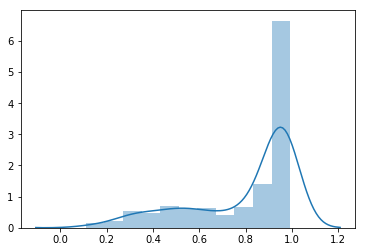

In [25]:
import seaborn as sns
%matplotlib inline

print(labels_test.mean())

sns.distplot(y_predict)

In [26]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = LimeTabularExplainer(
    train,
    class_names=['BrokeUp', 'StayedTogether'],
    feature_names=list(data.columns),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

Couples probability of staying together: 0.927016


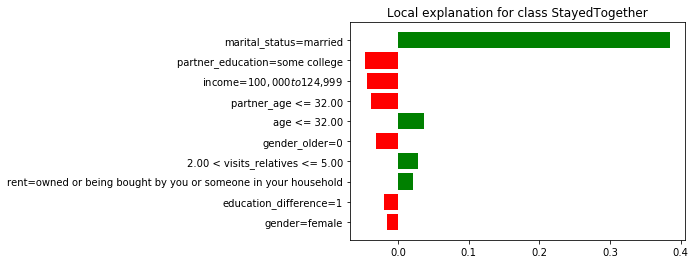

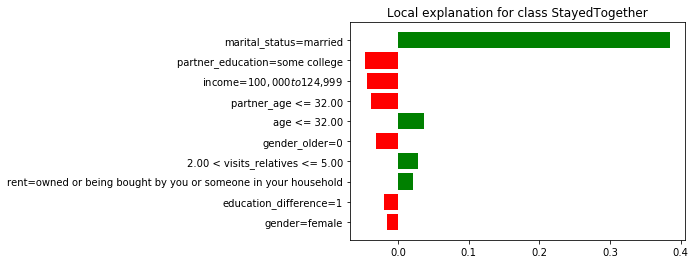

In [27]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
example = 3
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.946867


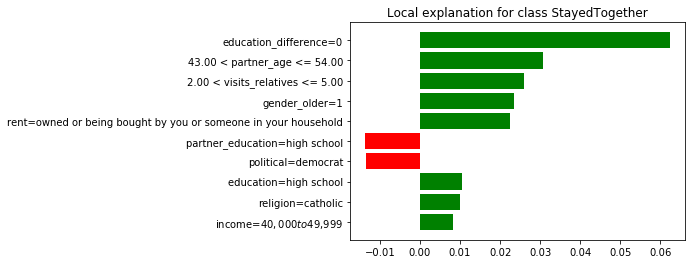

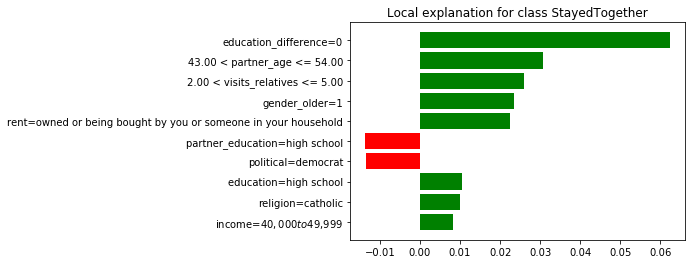

In [28]:
# Explain another prediction ("local interpretability"): 
example = 13
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [29]:
# and we see differences in explaining the model's predictions.

Couples probability of staying together: 0.805162


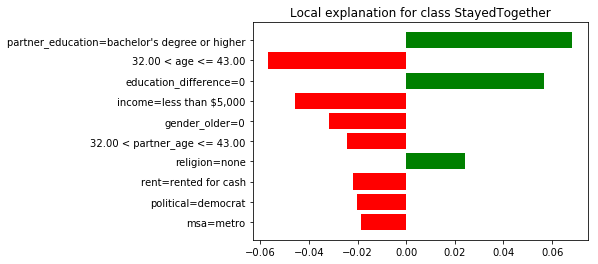

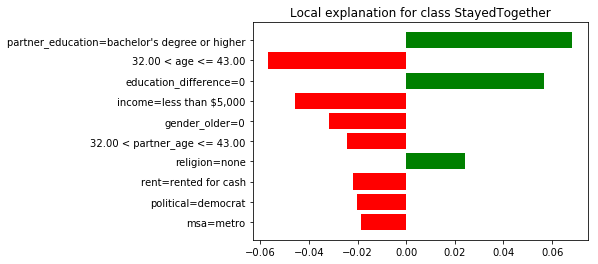

In [30]:
# Using LIME for for relationship management (not advised): Current chance of relationship success.
current = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 18, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(current), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.842065


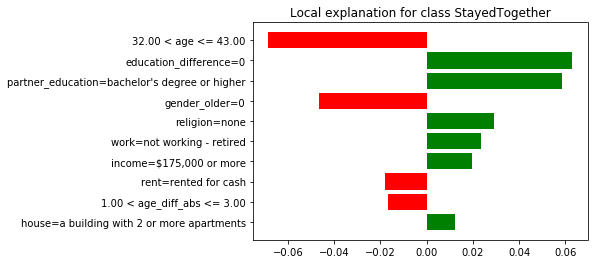

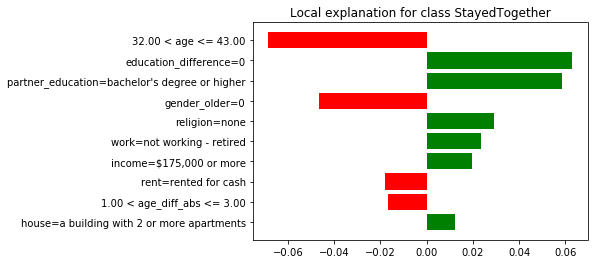

In [31]:
# Should I ask for a pay increase? It doesn't matter much.
increase_income = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(increase_income), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.879014


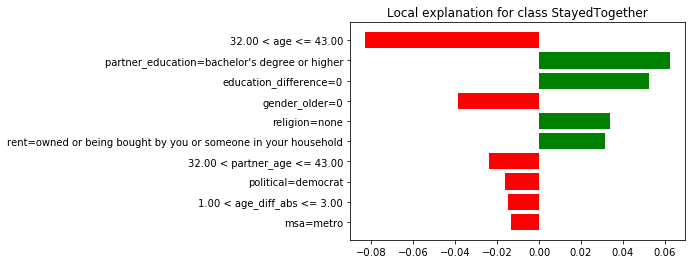

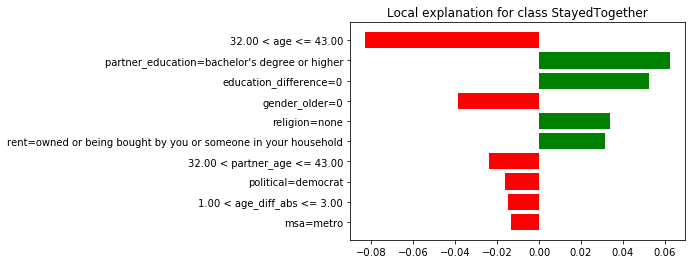

In [32]:
# Should I buy a house? Maybe?
buy_house = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(buy_house), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.975804


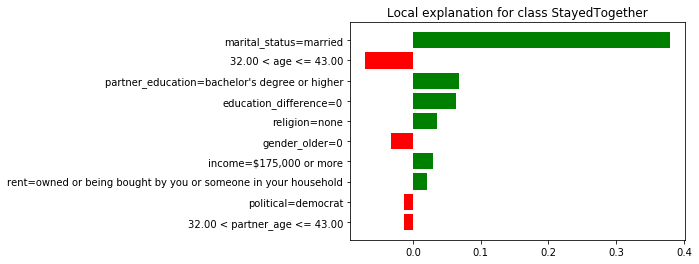

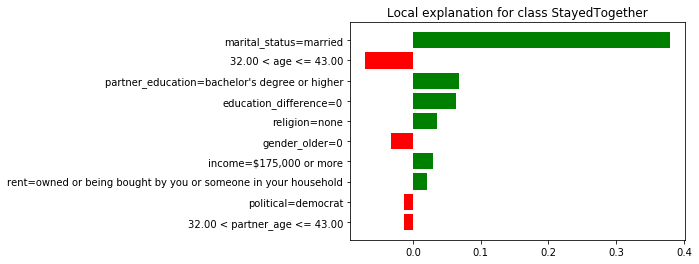

In [33]:
# Really, it's best to get married.
get_married = [34, 36, 2, 0, 1, 0, 2, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(get_married), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()